# Assignment — Epidemics on graphs

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import trange

### Task 1. Probabilistic node-level models. SIS (1 point)

Let us consider epidemic models on networks. SIS model is described by a dynamic form

$$S \to_{\beta SI} I \to_{\gamma I} S$$

To model epidemics on networks, we need to use probabilistic approach. First, let us define a function that gives us a random sample of available nodes by given probability.

Here is a function `select_nodes` that takes a np.array `vec`, where an i-th element is a number of neighbors that can affect to i-th node with probability `proba`. For example, `vec` can represent the number of infected neighbors, say [0, 2, 1] and then the probability is an infected rate $\beta$. That means the first node has no infected neighbors, the second has two infected neighbors, the third has one infected neighbor. Thereby, the second node has a $(1 - (1-\beta)^2)$ probability of getting infected.

In [24]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Let us infect a few random nodes and simulate a propogation of an epidemic.

Write a function `sis_networks` that takes a graph `G`, np.array with an initial indicator vector `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I`). Any node must be susceptible or infected at any step. Also the function takes rates `beta`, `gamma`, number of steps `k`. The function returns a np.array of shape `(k+1, 2, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column and `I` in the second.

_Hint: to calculate the number of infected neighbors, use `I @ A * S`_

In [48]:
def sis_networks(G, S, I, beta, gamma, k):
    #YOUR CODE
    np.random.seed(0)
    answer = [[S, I]]
    A = nx.to_numpy_array(G)
    for i in range(k):
        S_prev, I_prev = answer[-1]
        I_next = I_prev + select_nodes(I_prev @ A * S_prev, beta) - select_nodes(I_prev, gamma)
        S_next = 1 - I_next
        answer.append([S_next, I_next])
    return np.array(answer)

In [49]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050
sigma = 6.3853
mean = 16.0198
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < mean + 2*sigma
sigma = 5.953
mean = 34.2178
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < mean + 2*sigma

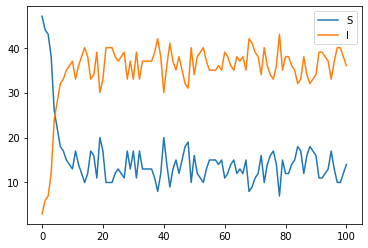

In [50]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I']);

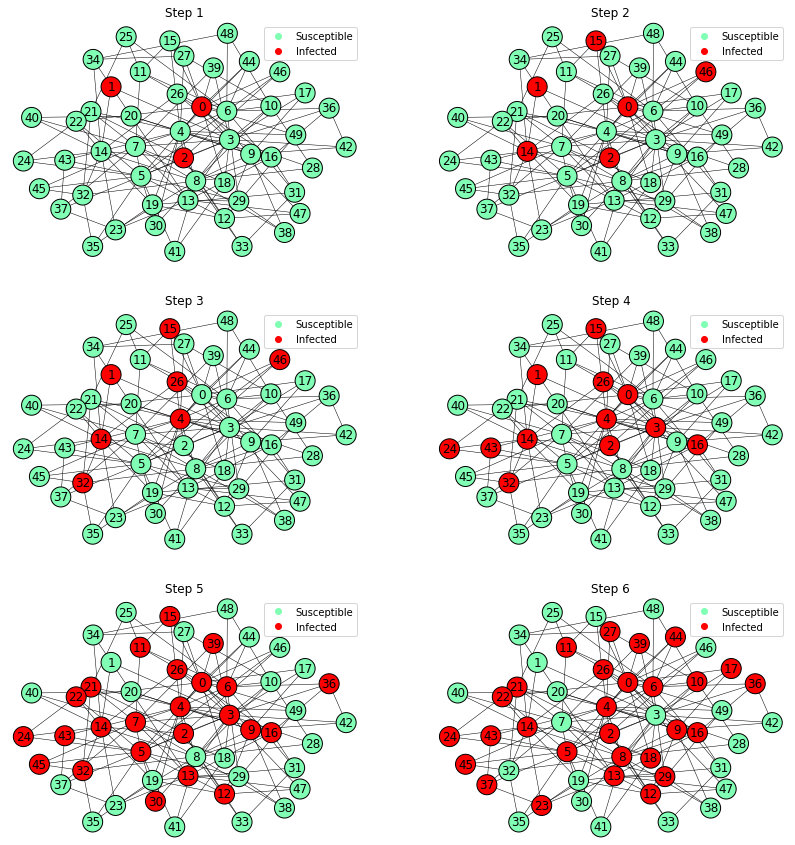

In [51]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 2. Probabilistic node-level models. SIRS (3 points)

Let us implement SIRS node-level model
$$S \to_{\beta SI} I \to_{\gamma I} R \to_{\delta R} S$$

Write a function `sirs_networks` that takes a graph `G`, np.array with initial indicator `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I` and `R`). Also the function takes rates `beta`, `gamma`, `delta`, number of steps `k`. The function returns a np.array of shape `(k+1, 3, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column, `I` in the second, `R` in the third.

In [68]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    # YOUR CODE HERE
    #np.random.seed(0)
    answer = [[S, I, R]]
    A = nx.to_numpy_array(G)
    for i in range(k):
        S_prev, I_prev, R_prev = answer[-1]
        I_gamma = select_nodes(I_prev, gamma)
        I_next = I_prev + select_nodes(I_prev @ A * S_prev, beta) - I_gamma
        R_next = R_prev + I_gamma - select_nodes(R_prev, delta)
        S_next = 1 - I_next - R_next
        answer.append([S_next, I_next, R_next])
    return np.array(answer)

In [69]:
G = nx.barabasi_albert_graph(40, 3, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

beta = 0.1
gamma = 0.3
delta = 0.1

epidemic = sirs_networks(G, S, I, R, beta, gamma, delta, 200)
assert epidemic.shape == (201, 3, 40)
assert (epidemic.sum(axis=1) == 1).sum() == 8040
assert (epidemic[200].sum(axis=1) == [40, 0, 0]).sum() == 3

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

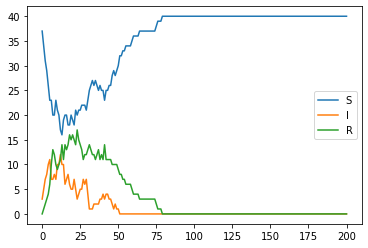

In [70]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

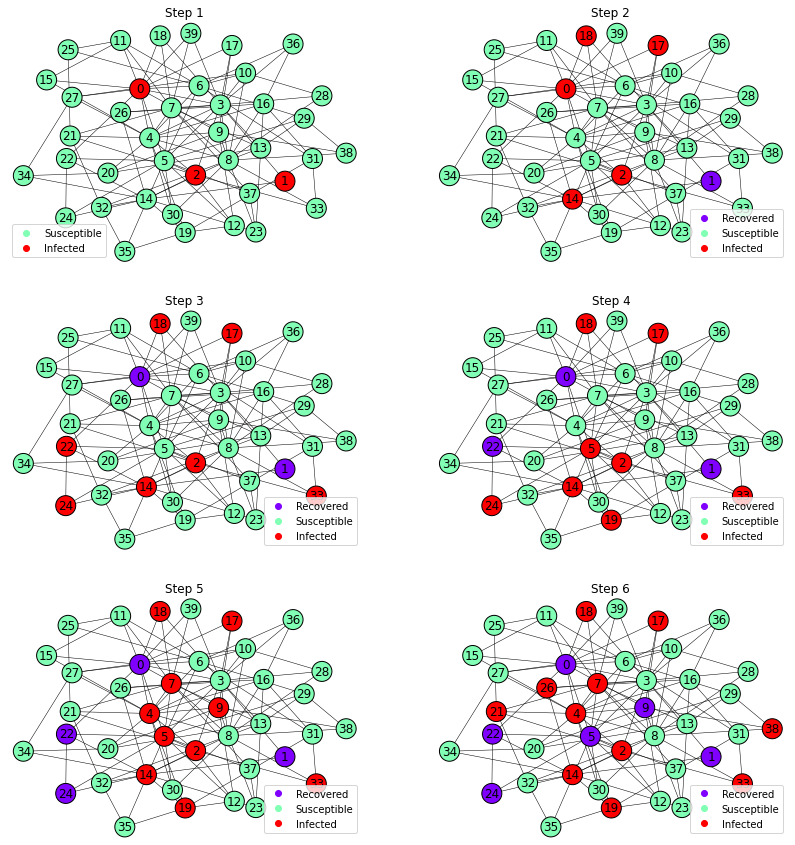

In [71]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

This model also can model "the second wave"

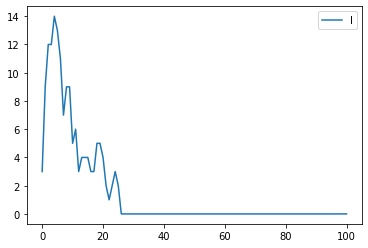

In [72]:
G = nx.barabasi_albert_graph(40, 3, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I

R = np.zeros(len(G))
epidemic = sirs_networks(G, S, I, R, 0.2, 0.4, 0.05, 100)
plt.plot(epidemic.sum(axis=2)[:, 1])
plt.legend(['I']);

### Task 3. Random Immunization for SIS model  (1 point)

Immunization strategies specify how vaccines, treatments or drugs are distributed in the population. Ideally, should a treatment or vaccine exist, it should be given to every infected individual or those at risk of contracting the pathogen.
However, it is costly to vaccinate all risky people. Given these constraints, immunization strategies aim to minimize the threat of a pandemic by most effectively distributing the available vaccines or treatments.

The general idea of immunization is to reduce infected rate $\beta$ to critical point. So the virus naturally dies out.

The immune nodes are invisible for the virus. So `randomly_immunized_sis_model` should work in following pipeline:

1. Select share `g` of nodes randomly (round number of selected nodes with int function)
2. Remove all edges adjacent to selected nodes
3. Run `sis_networks` model
4. Add removed edges

The `randomly_immunized_sis_model` method should return tuple with np.array of immunized nodes and output of `sis_networks` model for immunized graph.

_Hint: use `np.random.choice` to select random subsample_

In [73]:
def randomly_immunized_sis_model(g, G, S, I, beta, gamma, k):
    # YOUR CODE HERE
    np.random.seed(0)
    immune = np.random.choice(G.nodes, int(g*len(G.nodes)), replace=False)

    new_G = G.copy()
    for n1, n2 in G.edges():
      if (n1 in immune) or (n2 in immune):
        new_G.remove_edge(n1, n2)
    
    res = sis_networks(new_G, S, I, beta, gamma, k)

    return immune, res

In [74]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.1
g = 0.5

immune, epidemic = randomly_immunized_sis_model(g, G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050

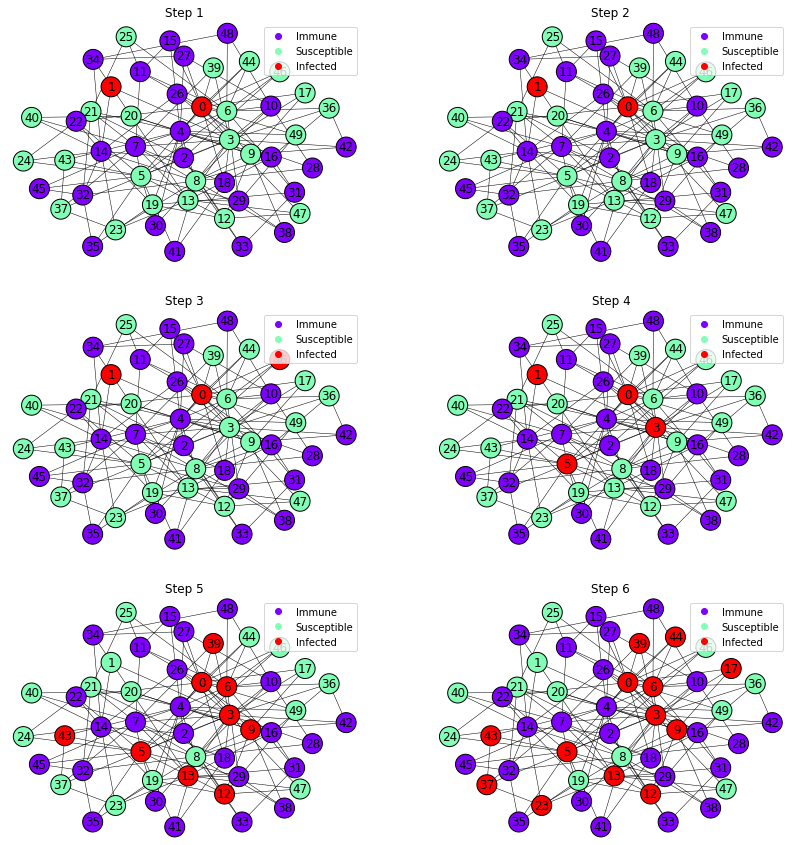

In [75]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    colors = I + 1
    colors[immune] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

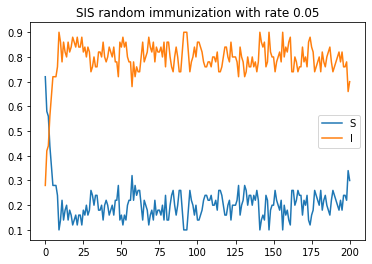

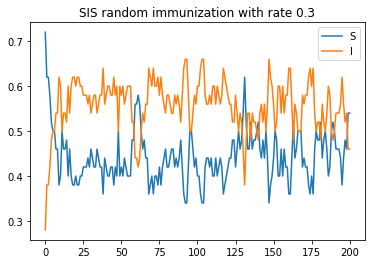

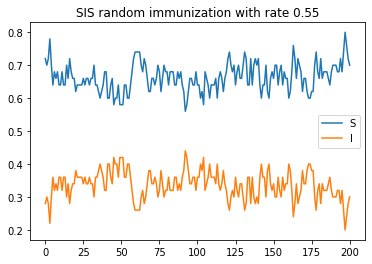

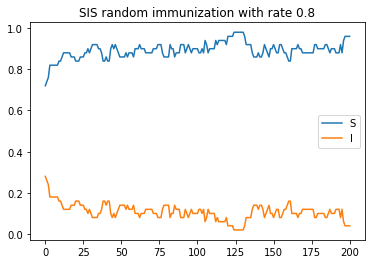

In [76]:
for i in range(1, 20, 5):
    immune, epidemic = randomly_immunized_sis_model(i / 20, G, S, I, beta, gamma, 200)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random immunization with rate {i / 20}")
    plt.legend(['S', 'I']);
    plt.show()

### Task 4. Selective Immunization for SIS (2 points)

The random immunization can help, but requires a large part of population to be vaccinized.
So we can propose the better immunization strategy named `Selective Immunization`.

The general idea of Selective Immuzation is to immunize hubs (nodes with the largest degree).

Here you need to define function `selectively_immunized_sis_model`. It works similar to the `randomly_immunized_sis_model`:

1. Select a part `g` of nodes with highest degree
2. Remove all edges adjacent to selected nodes
3. Run `sis_networks` model
4. Add removed edges

In [81]:
def selectively_immunized_sis_model(g, G, S, I, beta, gamma, k):
    # YOUR CODE HERE
    np.random.seed(0)
    immune = [node[1] for node in 
              sorted(G.degree, key=lambda x: x[1], reverse=True)[round(g*len(G.nodes)):]]

    new_G = G.copy()
    for n1, n2 in G.edges():
      if (n1 in immune) or (n2 in immune):
        new_G.remove_edge(n1, n2)
    
    res = sis_networks(new_G, S, I, beta, gamma, k)

    return immune, res

In [82]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.1
g = 0.3

immune, epidemic = selectively_immunized_sis_model(g, G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050

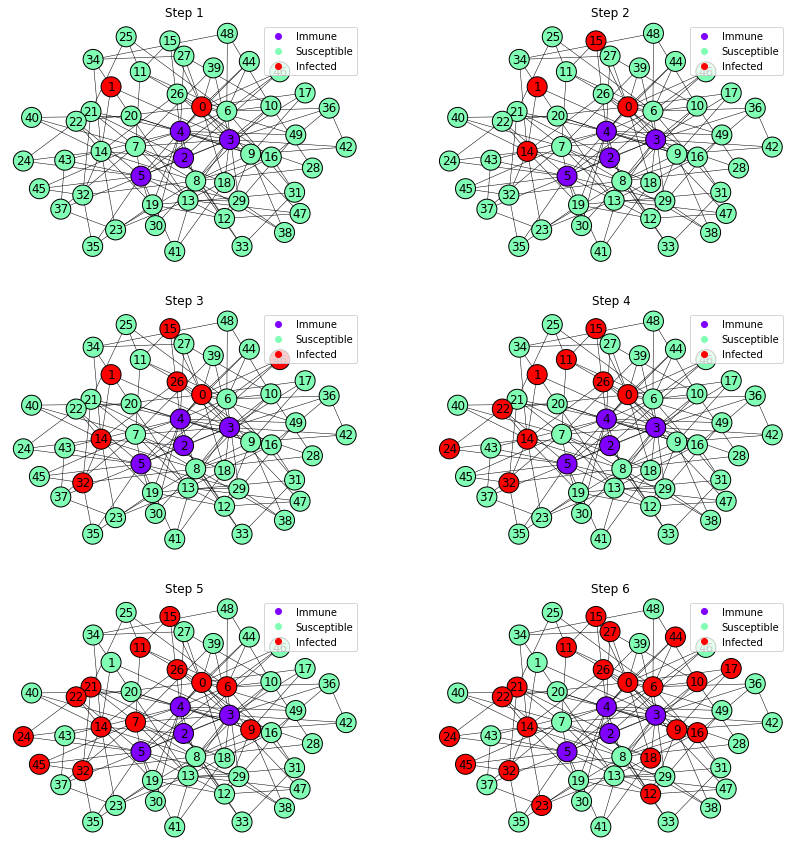

In [83]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    colors = I + 1
    colors[immune] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

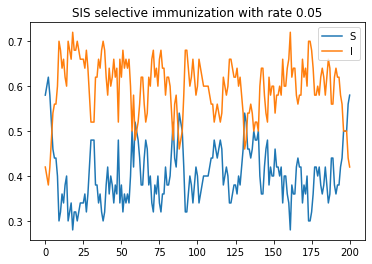

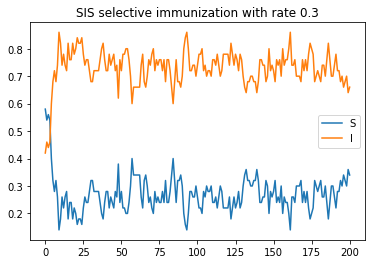

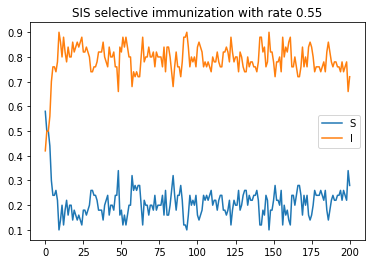

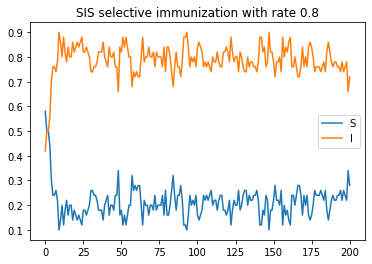

In [84]:
for i in range(1, 20, 5):
    immune, epidemic = selectively_immunized_sis_model(i / 20, G, S, I, beta, gamma, 200)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS selective immunization with rate {i / 20}")
    plt.legend(['S', 'I']);
    plt.show()

We can see that Selective Immunization requires less rate of population to be vaccinized

### Task 5. Degree assortativity and epidemics  (1 point)

Most real-world networks are assortative. So high degree nodes tend to connect to other high degree nodes.
Such nodes have a more significant probability of being infected because of the larger number of neighbours. So, when hubs are connected, the virus will spread faster.

Let us see that effect.

In the current task you need to realize `sir_network` that simulates node-level SIR model. Function takes similar input as SIRS except of `delta` probability.

In [85]:
def sir_networks(G, S, I, R, beta, gamma, k):
    # YOUR CODE HERE
    answer = [[S, I, R]]
    A = nx.to_numpy_array(G)
    for i in range(k):
        S_prev, I_prev, R_prev = answer[-1]
        dR = select_nodes(I_prev, gamma)
        I_next = I_prev + select_nodes(I_prev @ A * S_prev, beta) - dR
        R_next = R_prev + dR
        S_next = 1 - I_next - R_next
        answer.append([S_next, I_next, R_next])
    return np.array(answer)

In [86]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

beta = 0.1
gamma = 0.1
delta = 0.1

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))
epidemic = sir_networks(G, S, I, R, beta, gamma, 100)

assert epidemic.sum() == 5050
assert epidemic.shape == (101, 3, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050

Also, we need to define generator for networks with different levels of degree assortativities.
The `generate_network` function takes number of nodes (`n`), number of edges (`m`) and number of rewired edges (`k`), and type of assortativity as boolean.

The function should work as follows:

1. Generate random graph (using `nx.gnm_random_graph` with number of nodes equal to `n` and number of edges equal to `n-k`)
2. Sort nodes by the descending degree
3. Add k edges to the graph:
    1. If graph is assortative, then connect some first nodes from the sorted list. For instance, connect top(1)-top(2), top(2)-top(3) and etc.
    2. If graph is disassortative, then connect first nodes with the last nodes in the sorted list. For instance, connect top(1)-top(N), top(2)-top(N-1) and etc.

In [87]:
def generate_network(n, m, k, assortative=True):
    # YOUR CODE HERE
    G = nx.gnm_random_graph(n, m-k, seed=0)
    d = dict(G.degree)
    topNodes = sorted(d, key=d.get, reverse=True)
    ki = 0
    if assortative:
      for i in range(len(topNodes)):
        for j in range(i, len(topNodes)):
          if ki == k:
            break
          if not G.has_edge(topNodes[i], topNodes[j]):
            ki += 1
            G.add_edge(topNodes[i], topNodes[j])
    else:
      for i in range(len(topNodes)):
        for j in range(1, len(topNodes)-i):
          if ki == k:
            break
          if not G.has_edge(topNodes[i], topNodes[-j]):
            ki += 1
            G.add_edge(topNodes[i], topNodes[-j])

    return G      

In [88]:
G = generate_network(1000, 2000, 50, assortative=True)
assert G.number_of_nodes() == 1000
assert G.number_of_edges() == 2000
assert round(nx.degree_assortativity_coefficient(G), 4) > 0.08

G = generate_network(1000, 2000, 50, assortative=False)
assert round(nx.degree_assortativity_coefficient(G), 4) < -0.08

Let us generate some epidemic trajectories for graphs with different degree assortativity

In [89]:
beta = 0.1
gamma = 0.1
delta = 0.1

In [90]:
disassortative = np.zeros(51)
for i in trange(50):
    G = generate_network(1000, 2000, 50, assortative=False)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    disassortative += epidemic.sum(axis=2)[:, 1] / 50

In [91]:
neutral = np.zeros(51)
for i in trange(50):
    G = nx.gnm_random_graph(1000, 2000, seed=i)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    neutral += epidemic.sum(axis=2)[:, 1] / 50

In [92]:
assortative = np.zeros(51)
for i in trange(50):
    G = generate_network(1000, 2000, 50, assortative=True)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    assortative += epidemic.sum(axis=2)[:, 1] / 50

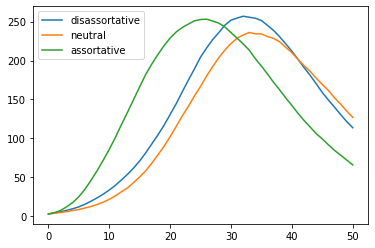

In [93]:
plt.plot(disassortative, label='disassortative')
plt.plot(neutral, label='neutral')
plt.plot(assortative, label='assortative')
plt.legend();

Given that hubs are the first to be infected in a network, assortativity accelerates the spread of a pathogen. In contrast disassortativity slows the spreading process.

### Task 6. Self-isolation  (2 points)

In this task we will see how self-isolation helps to beat epidemics.

The general idea is similar to the immunization: we make some nodes invisible for the virus.

Here you need to define the `random_self_isolation` function, that works similarly to the `randomly_immunized_sis_model`, but after some steps all isolated nodes become visible for the virus.

1. Select part (with rate `g`) of nodes randomly
2. Remove all edges adjacent to selected nodes
3. Run `sis_networks` model for number of steps `t` (self-isolation period)
4. Add all removed edges
5. Run `sis_networks` model for number of steps `k - t` keeping previous state

_Hint: use `np.random.choice` to select random subsample_

In [103]:
def self_isolation_sis_model(g, t, G, S, I, beta, gamma, k):
    # YOUR CODE HERE
    np.random.seed(0)
    isolated = np.random.choice(G.nodes, int(g*len(G.nodes)), replace=False)
    new_G = G.copy()
    for n1, n2 in G.edges():
      if (n1 in isolated) or (n2 in isolated):
        new_G.remove_edge(n1, n2)
    
    res_1 = sis_networks(new_G, S, I, beta, gamma, t)
    res = np.vstack((res_1, sis_networks(G, S, I, beta, gamma, k-t)))

    return isolated, res

In [104]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.1
g = 0.3
t = 3

immune, epidemic = self_isolation_sis_model(g, t, G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5100
assert epidemic.shape == (102, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5100

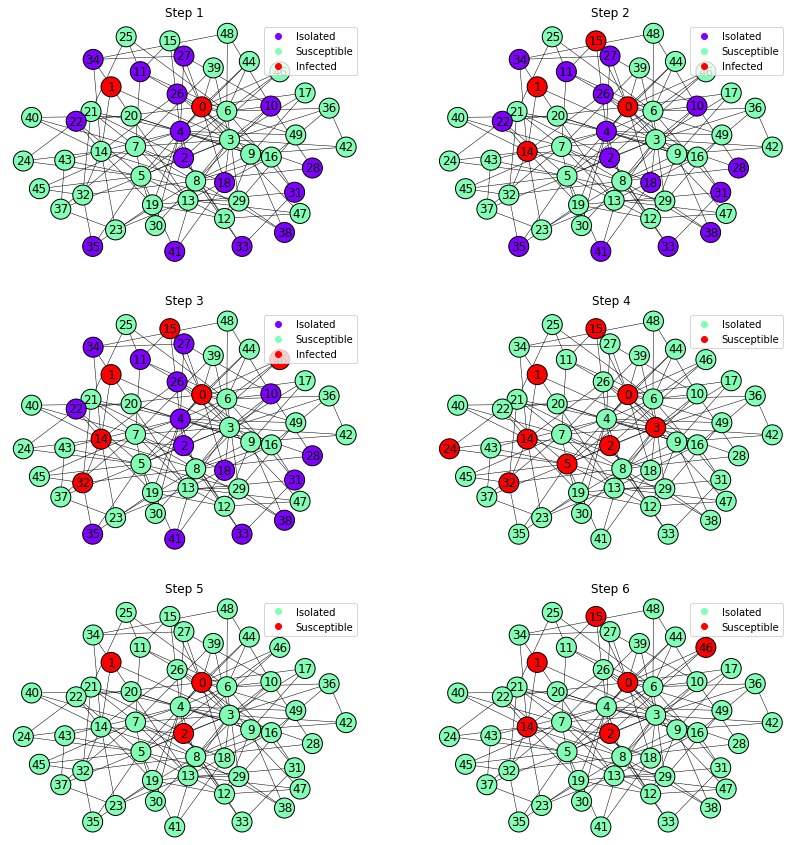

In [105]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for step, (S, I) in enumerate(epidemic[:6]):
    colors = I + 1
    if step < 3:
        colors[immune] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Isolated', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

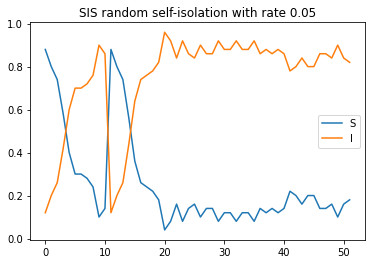

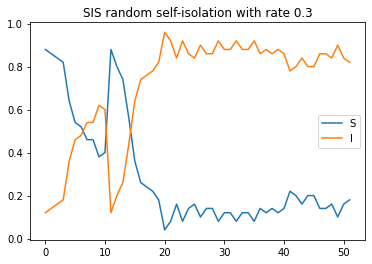

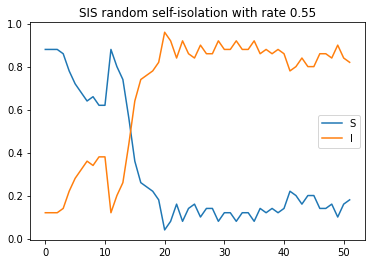

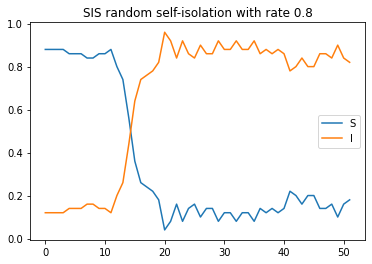

In [106]:
for i in range(1, 20, 5):
    immune, epidemic = self_isolation_sis_model(i / 20, 10, G, S, I, beta, gamma, 50)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random self-isolation with rate {i / 20}")
    plt.legend(['S', 'I']);
    plt.show()

Here we can see that high self-isolated rate of population just delays a case when all people to be infected

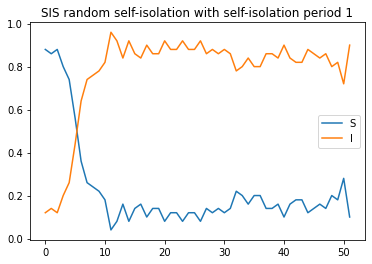

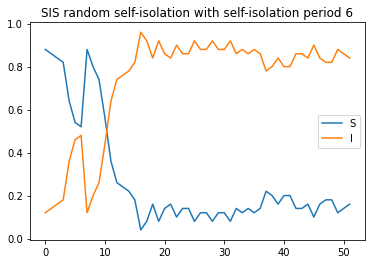

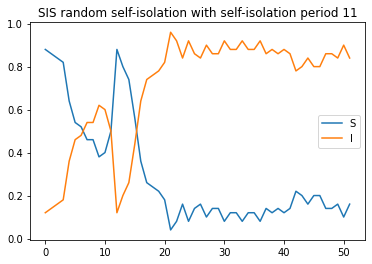

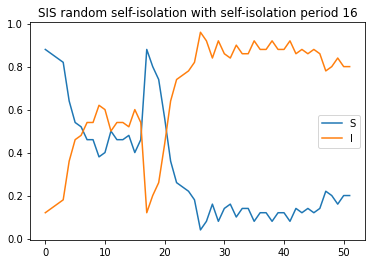

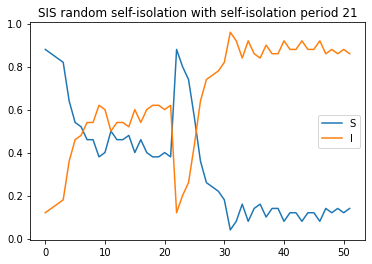

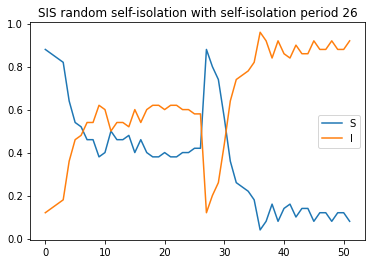

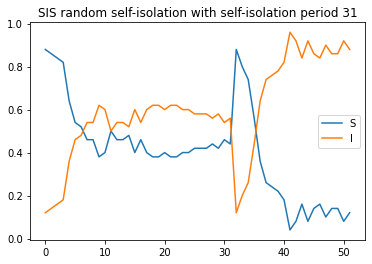

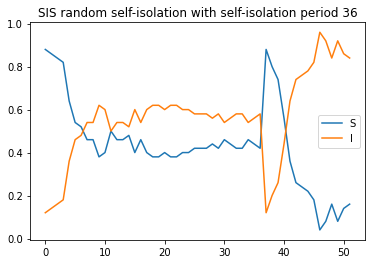

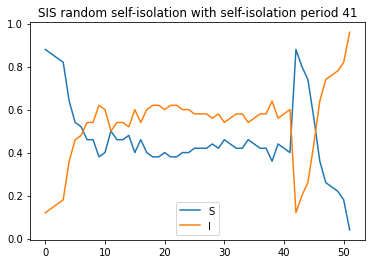

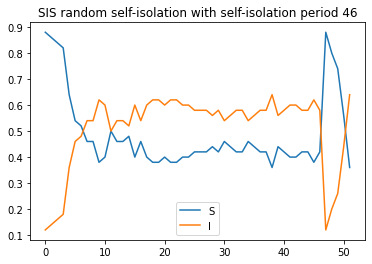

In [107]:
for i in range(1, 50, 5):
    immune, epidemic = self_isolation_sis_model(0.3, i, G, S, I, beta, gamma, 50)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random self-isolation with self-isolation period {i}")
    plt.legend(['S', 'I']);
    plt.show()

So, this model shows that the only efficient way to beat the pandemic is vaccination.